In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
from IPython.display import display
from sklearn.externals import joblib

basepath = os.path.expanduser('../')

## Load Data

In [3]:
%%time

app_train   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_train.pkl'))
app_test  = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_test.pkl'))

# additional tables

bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau.pkl'))
# bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau_balance.pkl'))
# prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/previous_application.pkl'))
# installments = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/installments_payments.pkl')) 
# pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/POS_CASH_balance.pkl'))
credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/credit_card_balance.pkl'))

CPU times: user 191 ms, sys: 536 ms, total: 727 ms
Wall time: 7.07 s


In [4]:
app_train.TARGET.value_counts(normalize=True)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

## Story

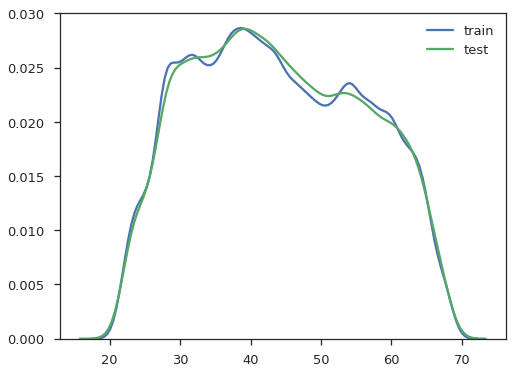

In [7]:
x = app_train.loc[:, ['DAYS_BIRTH', 'TARGET']]
x.loc[:, 'age'] = -x.DAYS_BIRTH / 365
y = app_test.loc[:, ['DAYS_BIRTH']]
y.loc[:, 'age'] = -y.DAYS_BIRTH / 365

plt.figure(figsize=(8, 6))
sns.kdeplot(x['age'], label='train')
sns.kdeplot(y['age'], label='test');

Very similar distribution of age in train and test set.

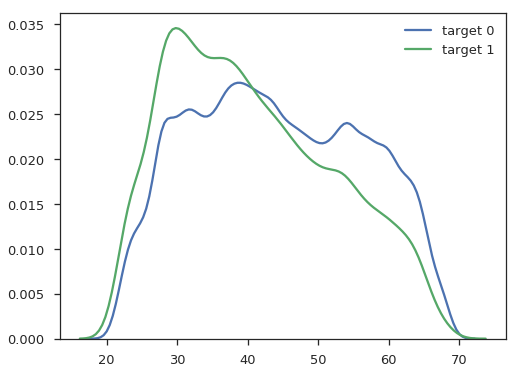

In [6]:
# relationship of age with target
plt.figure(figsize=(8, 6))
sns.kdeplot(x[x.TARGET == 0]['age'], label='target 0')
sns.kdeplot(x[x.TARGET == 1]['age'], label='target 1');

As we can clearly see that age is a very important feature as younger people are the one most susceptible to default.

Tasks

1. How is the distribution of active to closed loans appear in different age groups ?
1. Look at density of loans by age.

### Distribution of loans by age

In [13]:
num_active_loans = bureau[bureau.CREDIT_ACTIVE == 'Active'].groupby('SK_ID_CURR').size()\
                   .reset_index().rename(columns={0: 'num_active_loans'})

num_closed_loans = bureau[bureau.CREDIT_ACTIVE == 'Closed'].groupby('SK_ID_CURR').size()\
                   .reset_index().rename(columns={0: 'num_closed_loans'})

comp = num_active_loans.merge(num_closed_loans, on='SK_ID_CURR', how='inner')
comp.head()

,SK_ID_CURR,num_active_loans,num_closed_loans
0,100001,3,4
1,100002,2,6
2,100003,1,3
3,100005,2,1
4,100008,1,2


In [14]:
x = app_train.loc[:, ['SK_ID_CURR', 'DAYS_BIRTH']]
x.loc[:, 'age'] = -x.DAYS_BIRTH / 365
x.drop('DAYS_BIRTH', axis=1, inplace=True)

x = x.merge(comp, on='SK_ID_CURR', how='left')
x.head()

,SK_ID_CURR,age,num_active_loans,num_closed_loans
0,100002,25.920548,2.0,6.0
1,100003,45.931507,1.0,3.0
2,100004,52.180822,NaN,NaN
3,100006,52.068493,NaN,NaN
4,100007,54.608219,NaN,NaN


In [26]:
x.loc[:, 'age_group'], mapper = pd.cut(x.age, bins=8, labels=np.arange(8), retbins=True)

In [27]:
x.age_group.value_counts()

3    51100
2    49708
1    47520
5    42345
4    42340
6    37281
0    19016
7    18201
Name: age_group, dtype: int64

In [28]:
mapper

array([20.46920548, 26.59315068, 32.66849315, 38.74383562, 44.81917808,
       50.89452055, 56.96986301, 63.04520548, 69.12054795])

In [20]:
x[x.age_group == '(26.593, 32.668]']

,SK_ID_CURR,age,num_active_loans,num_closed_loans,age_group


In [32]:
def plot_loan_distribution_by_age(age_group):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(x[x.age_group == age_group]['num_active_loans'], label='num active loans')
    sns.kdeplot(x[x.age_group == age_group]['num_closed_loans'], label='num closed loans')
    plt.title('Number of examples: {}'.format(x[x.age_group == age_group].shape[0] / len(x)));

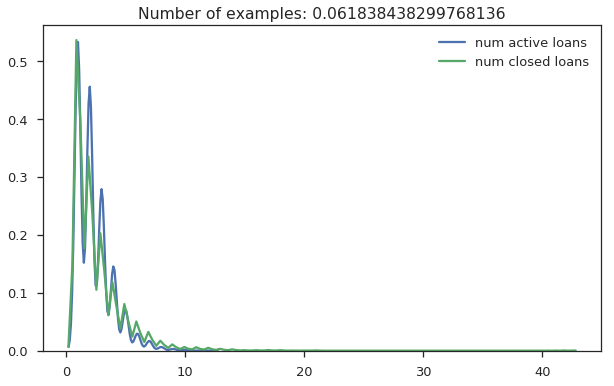

In [33]:
plot_loan_distribution_by_age(age_group=0)

Young peope have very few closed loans because of their age which makes sense.

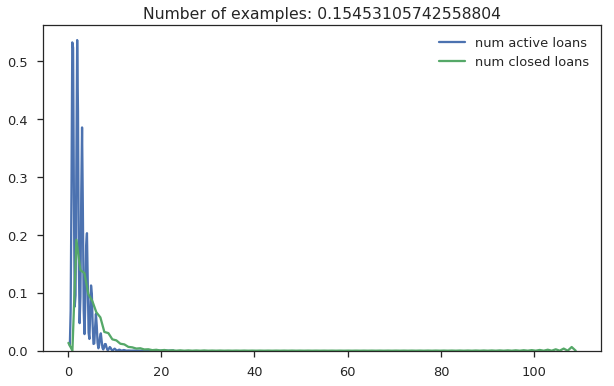

In [34]:
plot_loan_distribution_by_age(age_group=1)

Medium age people have slightly more number of closed loans compared to very young people, but active loans are quite few for this age group as well.

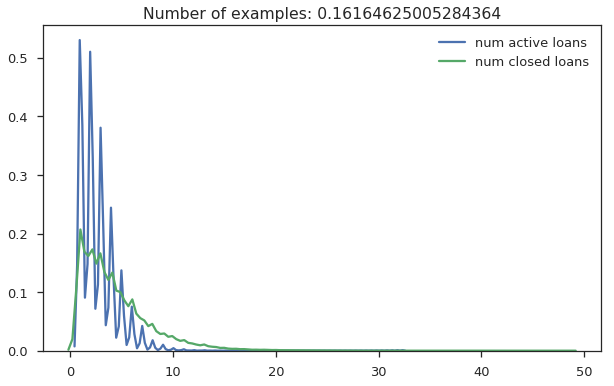

In [35]:
plot_loan_distribution_by_age(age_group=2)

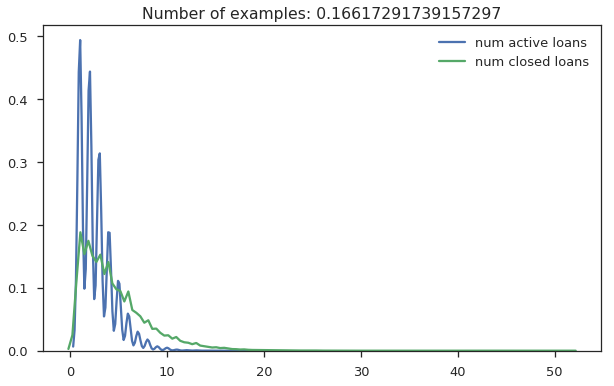

In [36]:
plot_loan_distribution_by_age(age_group=3)

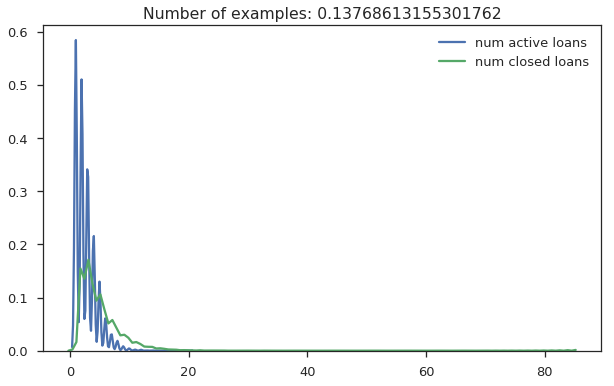

In [37]:
plot_loan_distribution_by_age(age_group=4)

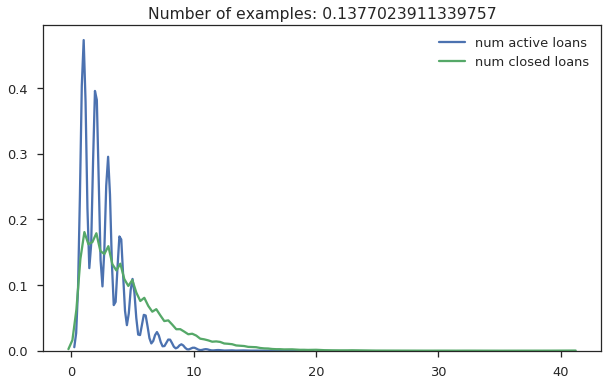

In [38]:
plot_loan_distribution_by_age(age_group=5)

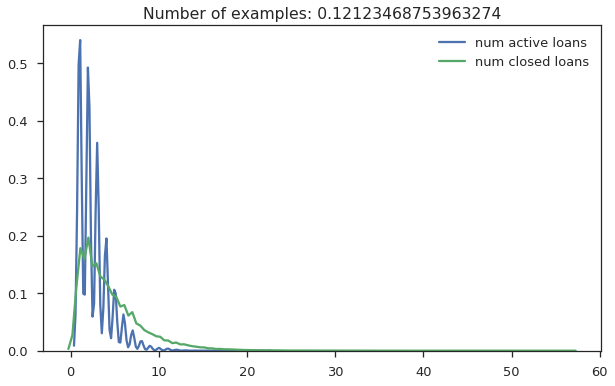

In [39]:
plot_loan_distribution_by_age(age_group=6)

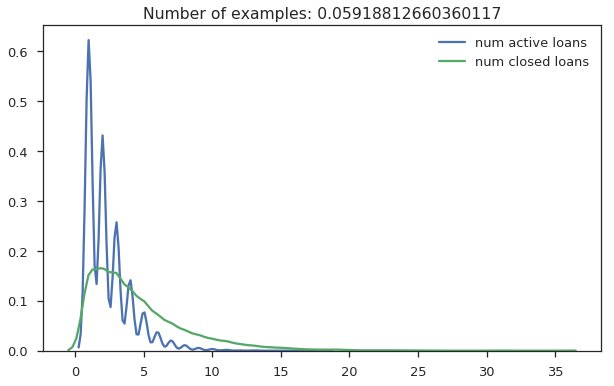

In [40]:
plot_loan_distribution_by_age(age_group=7)

As we move towards older people there are many more closed loans.

### Density of loans

Density of loans is defined as number of active loans applied for in a given duration.

In [45]:
tmp = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'DAYS_CREDIT']]
tmp.head()

,SK_ID_CURR,DAYS_CREDIT
1,215354,-208
2,215354,-203
3,215354,-203
4,215354,-629
5,215354,-273


In [57]:
# look at number of active loans applied for in last 12 months
active_loans_12_months = tmp.loc[tmp.DAYS_CREDIT >= -365].groupby('SK_ID_CURR').size()\
                          .reset_index().rename(columns={0: 'active_loans_12_months'})
active_loans_12_months.head()

,SK_ID_CURR,active_loans_12_months
0,100001,2
1,100002,1
2,100005,2
3,100008,1
4,100009,1


In [58]:
active_loans_12_months.active_loans_12_months.value_counts()

1     97204
2     41308
3     14174
4      4566
5      1457
6       480
7       152
8        48
9        16
10       13
12        4
11        4
15        2
17        1
13        1
Name: active_loans_12_months, dtype: int64

In [59]:
x = app_train.loc[:, ['SK_ID_CURR', 'DAYS_BIRTH', 'TARGET']]
x.loc[:, 'age'] = -x.DAYS_BIRTH / 365
x.drop('DAYS_BIRTH', axis=1, inplace=True)

comp = x.merge(active_loans_12_months, on='SK_ID_CURR', how='left'); comp.head()

,SK_ID_CURR,TARGET,age,active_loans_12_months
0,100002,1.0,25.920548,1.0
1,100003,0.0,45.931507,NaN
2,100004,0.0,52.180822,NaN
3,100006,0.0,52.068493,NaN
4,100007,0.0,54.608219,NaN


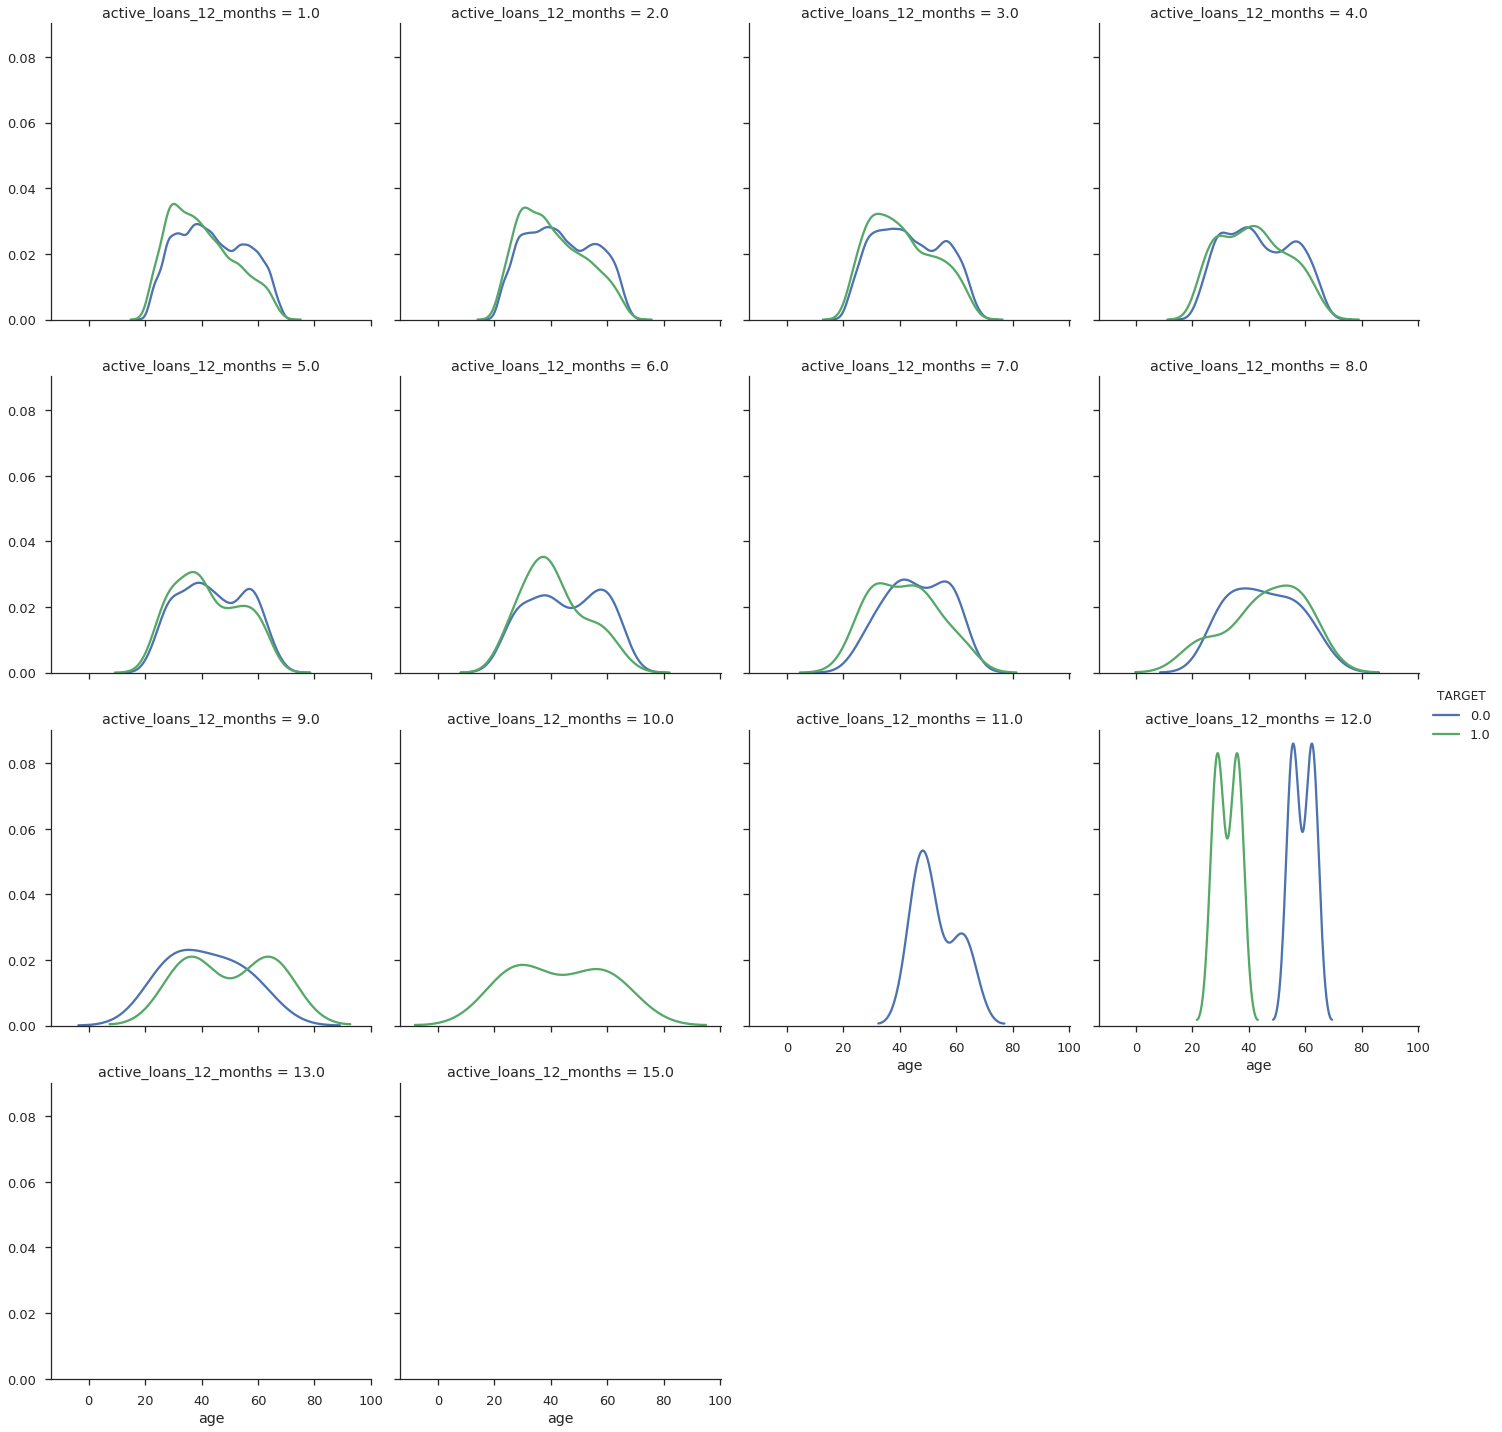

In [60]:
g = sns.FacetGrid(data=comp,
                  col='active_loans_12_months',
                  hue='TARGET',
                  col_wrap=4,
                  size=5
                 )
g = g.map(sns.kdeplot, 'age').add_legend()

### Loan Duration

- Mean loan duration of loans applied by a user.

In [89]:
tmp = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE']]
tmp.loc[:, 'duration'] = tmp.DAYS_CREDIT_ENDDATE - tmp.DAYS_CREDIT
tmp.head()

,SK_ID_CURR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,duration
1,215354,-208,1075.0,1283.0
2,215354,-203,528.0,731.0
3,215354,-203,NaN,NaN
4,215354,-629,1197.0,1826.0
5,215354,-273,27456.0,27729.0


In [90]:
res = tmp[tmp.DAYS_CREDIT_ENDDATE > 0].groupby('SK_ID_CURR')['duration'].mean()
res.head()

SK_ID_CURR
100001    1339.666626
100002    1822.000000
100003    1822.000000
100005     822.500000
100008     549.000000
Name: duration, dtype: float32

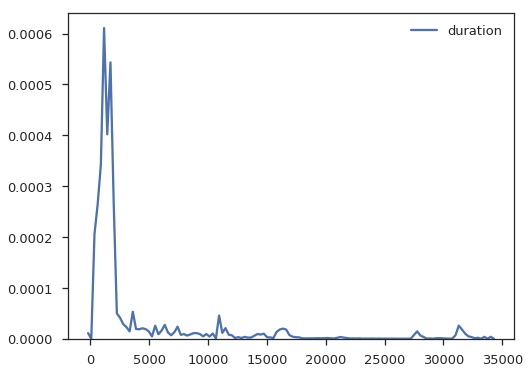

In [91]:
plt.figure(figsize=(8, 6))
sns.kdeplot(res);

In [92]:
x = app_train.loc[:, ['SK_ID_CURR', 'DAYS_BIRTH', 'TARGET']]
x.loc[:, 'age'] = -x.DAYS_BIRTH / 365
x.drop('DAYS_BIRTH', axis=1, inplace=True)

x.loc[:, 'mean_days_credit'] = x.SK_ID_CURR.map(res)
x.head()

,SK_ID_CURR,TARGET,age,mean_days_credit
0,100002,1.0,25.920548,1822.0
1,100003,0.0,45.931507,1822.0
2,100004,0.0,52.180822,NaN
3,100006,0.0,52.068493,NaN
4,100007,0.0,54.608219,NaN


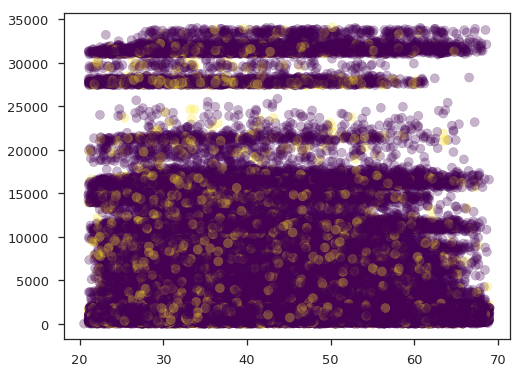

In [93]:
plt.figure(figsize=(8, 6))
plt.scatter(x.age, x.mean_days_credit, c=x.TARGET, cmap='viridis', alpha=.3);

### Maximum amount overdue on the Credit Bureau Credit so far.

In [108]:
tmp = bureau.loc[:, ['SK_ID_CURR', 'AMT_CREDIT_MAX_OVERDUE']]
tmp[tmp.AMT_CREDIT_MAX_OVERDUE > 0].shape[0] / len(tmp)

0.07066419331308975

Only 7% values have non-zero value

In [99]:
tmp[tmp.AMT_CREDIT_MAX_OVERDUE >= 0].shape[0] / len(tmp)

0.34486736408401636

Only 34% values are not null

In [105]:
tmp[tmp.AMT_CREDIT_MAX_OVERDUE >= 0 ].AMT_CREDIT_MAX_OVERDUE.describe()

count    5.919400e+05
mean     3.825358e+03
std      2.059873e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.159872e+08
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64

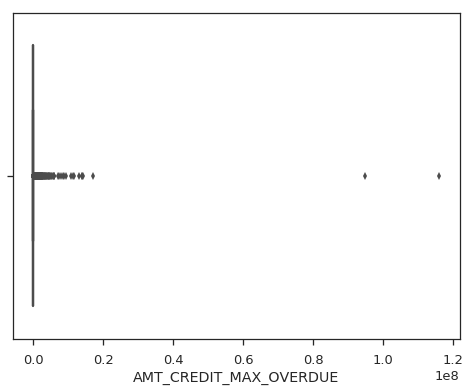

In [102]:
plt.figure(figsize=(8, 6))
sns.boxplot(tmp[tmp.AMT_CREDIT_MAX_OVERDUE >= 0].AMT_CREDIT_MAX_OVERDUE);

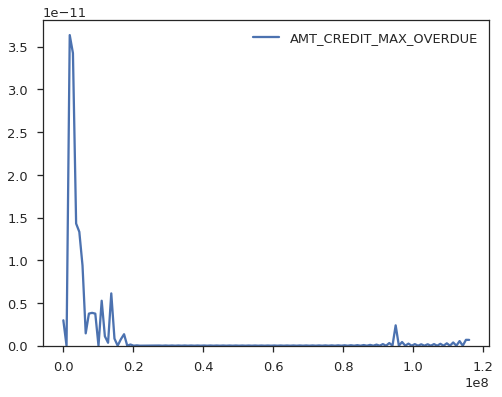

In [101]:
plt.figure(figsize=(8, 6))
sns.kdeplot(tmp[tmp.AMT_CREDIT_MAX_OVERDUE >= 0].AMT_CREDIT_MAX_OVERDUE);

In [116]:
total_credit_overdue = tmp.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].sum()
total_credits        = tmp.groupby('SK_ID_CURR').size()
res = total_credit_overdue / total_credits
res.head()

SK_ID_CURR
100001       0.000000
100002    1050.643066
100003       0.000000
100004       0.000000
100005       0.000000
dtype: float32

In [117]:
res = app_train.SK_ID_CURR.map(res)
print(res[res.isnull()].shape[0] / len(res))

0.14314935075493235


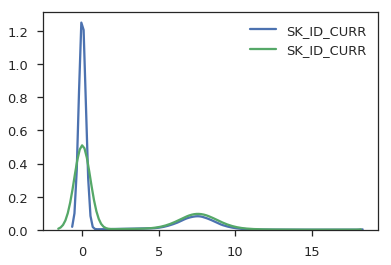

In [118]:
sns.kdeplot(res[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(res[app_train.TARGET == 1].map(np.log1p));

### Current Credit amount for Credit Bureau credit

In [134]:
tmp = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'AMT_CREDIT_SUM']]
tmp.head()

,SK_ID_CURR,AMT_CREDIT_SUM
1,215354,225000.0
2,215354,464323.5
3,215354,90000.0
4,215354,2700000.0
5,215354,180000.0


In [135]:
tmp[tmp.AMT_CREDIT_SUM.isnull()].shape[0] / len(tmp)

1.26861896553638e-05

In [136]:
tmp.AMT_CREDIT_SUM.describe()

count    6.305990e+05
mean     5.323881e+05
std      1.266253e+06
min      0.000000e+00
25%      9.000000e+04
50%      2.126160e+05
75%      4.950000e+05
max      1.701000e+08
Name: AMT_CREDIT_SUM, dtype: float64

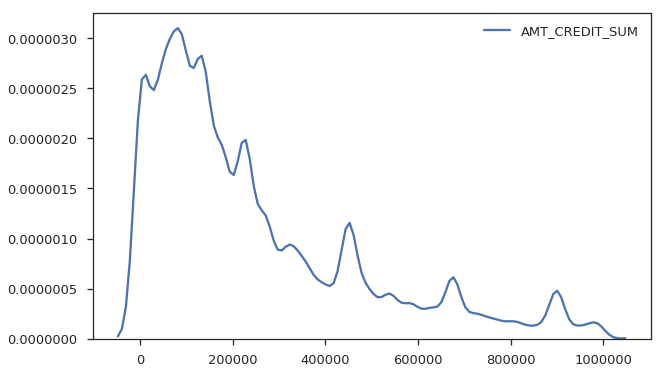

In [137]:
plt.figure(figsize=(10, 6))
sns.kdeplot(tmp[tmp.AMT_CREDIT_SUM < 1e6].AMT_CREDIT_SUM);

In [138]:
total_credit = tmp.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()
total_loans  = tmp.groupby('SK_ID_CURR').size()

res  = total_credit / total_loans

In [139]:
res  = app_train.SK_ID_CURR.map(res)
res[res.isnull()].shape[0] / len(res)

0.2938463989906052

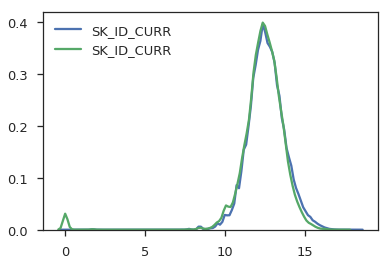

In [140]:
sns.kdeplot(res[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(res[app_train.TARGET == 1].map(np.log1p));

### How many times was the credit bureau credit prolonged ?

In [141]:
tmp = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'CNT_CREDIT_PROLONG']]
tmp[tmp.CNT_CREDIT_PROLONG.isnull()].shape[0] / len(tmp)

0.0

In [143]:
tmp[tmp.CNT_CREDIT_PROLONG == 0].shape[0] / len(tmp)

0.99110698105159

### Current Credit Limit of the card reported in Credit Bureau

In [145]:
tmp = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'AMT_CREDIT_SUM_LIMIT']]
tmp[tmp.AMT_CREDIT_SUM_LIMIT.isnull()].shape[0] / len(tmp)

0.2748431273360429

27% of values are null values.

In [148]:
tmp[tmp.AMT_CREDIT_SUM_LIMIT == 0].shape[0] / len(tmp)

0.6156116249898906

61% of the total values are zero.

### Type of credit ( car, cash ... )

In [176]:
bureau.CREDIT_TYPE.value_counts(dropna=False)

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: CREDIT_TYPE, dtype: int64

In [178]:
tmp = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'CREDIT_TYPE', 'AMT_CREDIT_SUM',
                                              'AMT_CREDIT_SUM_DEBT'
                                             ]]
tmp.head()

,SK_ID_CURR,CREDIT_TYPE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT
1,215354,Credit card,225000.0,171342.000000
2,215354,Consumer credit,464323.5,NaN
3,215354,Credit card,90000.0,NaN
4,215354,Consumer credit,2700000.0,NaN
5,215354,Credit card,180000.0,71017.382812


In [181]:
# total credit by different credit types
credit_by_type = tmp.groupby(['SK_ID_CURR', 'CREDIT_TYPE'])['AMT_CREDIT_SUM'].sum().unstack().fillna(0)
debt_by_type   = tmp.groupby(['SK_ID_CURR', 'CREDIT_TYPE'])['AMT_CREDIT_SUM_DEBT'].sum().unstack().fillna(0)

In [203]:
columns = [str(col) for col in credit_by_type.columns]
credit_by_type.columns = columns
credit_by_type = credit_by_type.reset_index()

In [204]:
res = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(credit_by_type, on='SK_ID_CURR', how='left')
res.head()

,SK_ID_CURR,TARGET,Consumer credit,Credit card,Microloan,Mortgage,Car loan,Loan for working capital replenishment,Another type of loan,Cash loan (non-earmarked),Loan for business development,Loan for the purchase of equipment,Unknown type of loan,Real estate loan,Loan for purchase of shares (margin lending),Mobile operator loan
0,100002,1.0,450000.0,31988.564453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,0.0,810000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### How many days before loan application did last information about info about Credit Bureau credit come ?

In [221]:
# relationship between credit amount and this feature
tmp = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'AMT_CREDIT_SUM', 
                                                    'AMT_CREDIT_SUM_DEBT',
                                                    'DAYS_CREDIT_UPDATE']]
tmp.loc[:, 'DAYS_CREDIT_UPDATE'] = -tmp.DAYS_CREDIT_UPDATE / 365
tmp.head()

,SK_ID_CURR,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DAYS_CREDIT_UPDATE
1,215354,225000.0,171342.000000,0.054795
2,215354,464323.5,NaN,0.043836
3,215354,90000.0,NaN,0.043836
4,215354,2700000.0,NaN,0.057534
5,215354,180000.0,71017.382812,0.084932


In [219]:
tmp.loc[:, 'derived'] = tmp.AMT_CREDIT_SUM.map(np.log1p) / tmp.DAYS_CREDIT_UPDATE
res = tmp.groupby('SK_ID_CURR')['derived'].sum()
res = app_train.SK_ID_CURR.map(res)

print(res[res.isnull()].shape[0] / len(res))

0.2938463989906052


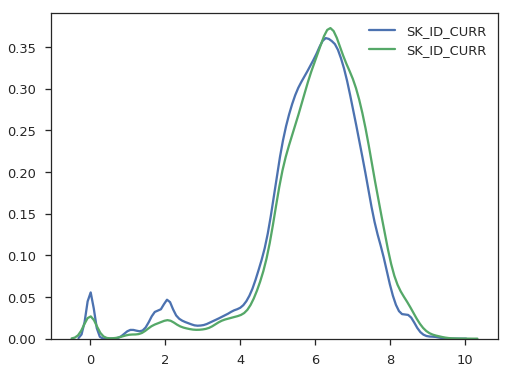

In [220]:
plt.figure(figsize=(8, 6))
sns.kdeplot(res[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(res[app_train.TARGET == 1].map(np.log1p));

In [222]:
tmp.loc[:, 'derived'] = tmp.AMT_CREDIT_SUM_DEBT.map(np.log1p) / tmp.DAYS_CREDIT_UPDATE
res = tmp.groupby('SK_ID_CURR')['derived'].sum()
res = app_train.SK_ID_CURR.map(res)

print(res[res.isnull()].shape[0] / len(res))

0.2938463989906052


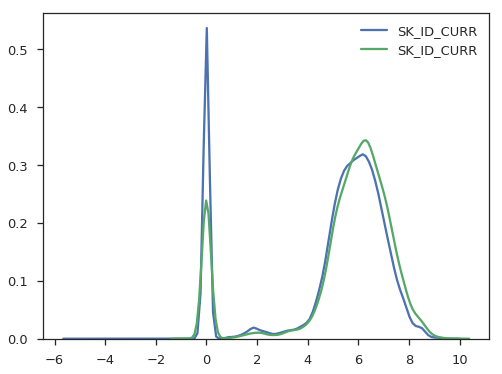

In [223]:
plt.figure(figsize=(8, 6))
sns.kdeplot(res[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(res[app_train.TARGET == 1].map(np.log1p));